# Nivell 1
#### Exercici 1
Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

**Información extraída de [Apache Server](https://httpd.apache.org/docs/2.4/logs.html)**:

**Ejemplo:**

*127.0.0.1 - frank [10/Oct/2000:13:55:36 -0700] "GET /apache_pb.gif HTTP/1.0" 200 2326 "Mozilla/4.08 [en] (Win98; I ;Nav)"*

- **127.0.0.1** This is the IP address of the client (remote host) which made the request to the server. **IP_User**
- **frank** This is the userid of the person requesting the document as determined by HTTP authentication.**User**
- **[10/Oct/2000:13:55:36 -0700]** The time that the request was received.**Time**
- **"GET /apache_pb.gif HTTP/1.0"** First, the method used by the client is GET. Second, the client requested the resource /apache_pb.gif, and third, the client used the protocol HTTP/1.0 **Method, Resource, Protocol**
- **200** This is the status code that the server sends back to the client.[Http Codes](https://developer.mozilla.org/es/docs/Web/HTTP/Status) **Status**
- **2326** The last part indicates the size of the object returned to the client **Size**
- **Mozilla/4.08 [en] (Win98; I ;Nav)** This is the identifying information that the client browser reports about itself. **Browser**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [53]:
df=pd.read_csv('Desktop/DataScience/datasets/akumenius/akumenius.txt', sep="- -", engine='python',header=None)

In [54]:
df.head()

,0,1
0,localhost 127.0.0.1,"[23/Feb/2014:03:10:31 +0100] ""OPTIONS * HTTP/..."
1,localhost 127.0.0.1,"[23/Feb/2014:03:10:31 +0100] ""OPTIONS * HTTP/..."
2,localhost 127.0.0.1,"[23/Feb/2014:03:10:31 +0100] ""OPTIONS * HTTP/..."
3,localhost 127.0.0.1,"[23/Feb/2014:03:10:31 +0100] ""OPTIONS * HTTP/..."
4,localhost 127.0.0.1,"[23/Feb/2014:03:10:31 +0100] ""OPTIONS * HTTP/..."


# Nivell 2
#### Exercici 2
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [55]:
#Dividimos la primera columna en User y IP_User
split=df.iloc[:,0].str.split(r'\s')
df['User'],df['IP_User']=split.str[0],split.str[1]

In [56]:
#Dividimos la segunda columna para obtener el resto de atributos (Time, Method,..)
df1=df.iloc[:,1].str.extract(r'(?P<Time>\[.*\])\s(?P<Method>\"\w*)\s(?P<Resource>[\/*].*?)\s(?P<Protocol>.*?\")\s(?P<Status>\d{1,3})\s(?P<Size>[\d-]*)\s(\"-\")\s(?P<Browser>\".*\")')
#Concatenamos los 2 dataframes y seleccionamos las columnas que queremos
df_processed=pd.concat([df,df1], axis=1)[["User","IP_User","Time","Method","Resource","Protocol","Status","Size","Browser"]]

In [57]:
#Miramos uno de los ítems
df_processed.iloc[40,:]

User                                        www.akumenius.com
IP_User                                         66.249.76.216
Time                             [23/Feb/2014:03:11:01 +0100]
Method                                                   "GET
Resource    /hoteles-baratos/ofertas-hotel-Venetur-Hotel-d...
Protocol                                            HTTP/1.1"
Status                                                    404
Size                                                     3100
Browser     "Mozilla/5.0 (compatible; Googlebot/2.1; +http...
Name: 40, dtype: object

In [58]:
#Eliminamos algunos símbolos([,],") que  han quedado al inicio y final de los valores
df_processed['Method']=df_processed['Method'].str.strip('\""')
df_processed['Protocol']=df_processed['Protocol'].str.strip('\""')
df_processed['Time']=df_processed['Time'].str.lstrip('[').str.rstrip(']')
df_processed['Browser']=df_processed['Browser'].str.strip('\""')

In [59]:
#El valor anterior ya limpio
df_processed.iloc[40,:]

User                                        www.akumenius.com
IP_User                                         66.249.76.216
Time                               23/Feb/2014:03:11:01 +0100
Method                                                    GET
Resource    /hoteles-baratos/ofertas-hotel-Venetur-Hotel-d...
Protocol                                             HTTP/1.1
Status                                                    404
Size                                                     3100
Browser     Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
Name: 40, dtype: object

#### Exercici 3
Geolocalitza les IP's. Aquí tens una pàgina d'interès: [IP2Location](https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/)

La web permite hacer la consulta de cada IP online así que en vez de usar la librería de IP2Location vamos a capturar los 
datos **via scraping.**

In [309]:
#Número de IP addresses
IPaddressNum=df_processed['IP_User'].unique().tolist()
len(IPaddressNum)

2921

**Como hay un límite de consultas gratis por día vamos a geolocalizar antes las más habituales.**

In [310]:
#Ordenamos de mayor a menor uso
IPaddress=df_processed['IP_User'].value_counts().index
IPaddress=IPaddress.tolist()

In [311]:
IPaddress[0:4]

['66.249.76.216', '80.28.221.123', '127.0.0.1', '217.125.71.222']

In [312]:
#Borramos localhost IP 127.0.0.1
IPaddress.pop(2)
IPaddress[0:4]

['66.249.76.216', '80.28.221.123', '217.125.71.222', '66.249.75.148']

In [103]:
# Guardamos IPs en un txt
f=open('IPaddress.txt','w')
for ele in IPaddress:
    f.write(ele+'\n')
f.close()

**Esta parte se puede realizar sin ejecutar la parte superior exceptuando las librerías**

In [3]:
from scrapy import Selector
import requests
import json
import os.path

In [61]:
#Miramos si existe el fichero con todas las IPs (IPaddress) y si ya se ha generado un primer fichero con datos de 
#geolocalización (data). Si el fichero data no existe creamos una lista con las n primeras IP's del fichero IPaddress.
#Si, en cambio, data ya existe, la lista contendrá las n siguientes IP's y así sucesivamente.

#IP2Location desde web tiene una cuota de consultas de 50 créditos por día como máximo.Debemos vigilar no superar el límite
#diario
if os.path.isfile('IPaddress.txt'):
    print ("File IPaddress existe")
    with open('IPaddress.txt') as f:
        IPaddress = f.read().splitlines()
    if os.path.isfile('data.json'):
        print ("File data existe")
        with open('data.json', 'r') as fp:
            data = json.load(fp)
        #quitamos IP's ya consultadas de la lista total de IP's
        usedIP=list(data.keys())    
        IPaddress=[i for i in IPaddress if i not in usedIP]
    else:
        print ("File data no existe")       
else:
    print ("File IPaddress no existe. Ejecutar celdas superiores!!!")
    
IPaddress=IPaddress[0:3]

File IPaddress existe
File data existe


In [65]:
#Extraemos ciudad, longitud y altitud
#Hay dos errores, he puesto 'alt' por 'lat' y los campos de longitud y latitud están cambiados!!!!
from collections import defaultdict
IPcity=defaultdict(dict)
n=len(IPaddress)
i=0
for ip in IPaddress:
    url="https://www.ip2location.com/"+ip
    html=requests.get(url).content
    sel=Selector(text=html)    
    location=sel.xpath('//div//table/tbody/tr/td/text()')[4].get().split()
    if len(location)>1: #Evitamos las IP's para las que no ofrece datos
        IPcity[ip]['city']=sel.xpath('//div//table/tbody/tr/td/text()')[3].get()
        IPcity[ip]['long']=location[0].strip(',')
        IPcity[ip]['alt']=location[1]
    i+=1
    print('%s/%s realizado'%(i,n))

['-']
1/3 realizado
['36.133260,', '-5.450510', '(36°7\'60"N', '5°27\'2"W)']
2/3 realizado
['40.416500,', '-3.702560', '(40°24\'59"N', '3°42\'9"W)']
3/3 realizado


In [66]:
#Actualizamos diccionario y guardamos en data.json
data.update(IPcity)
with open('data.json', 'w') as fp:
    json.dump(data, fp)

In [67]:
#Miramos uno de los valores guardados:
data['66.249.76.216']

{'city': 'Mountain View', 'long': '37.405992', 'alt': '-122.078515'}

In [68]:
#La cantidad de registros guardados hasta ahora
len(data)

94

# Nivell 3
#### Exercici 4
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

### 1.Visualización IP's en mapas
**Esta parte se puede realizar sin ejecutar la parte superior exceptuando las librerías**

In [19]:
import cartopy.crs as crs
import cartopy.feature as cfeature

In [69]:
if os.path.isfile('data.json'):
    print ("File data existe")
    with open('data.json', 'r') as fp:
        data = json.load(fp)        
else:
    print ("File data no existe")

File data existe


#### Mapamundi

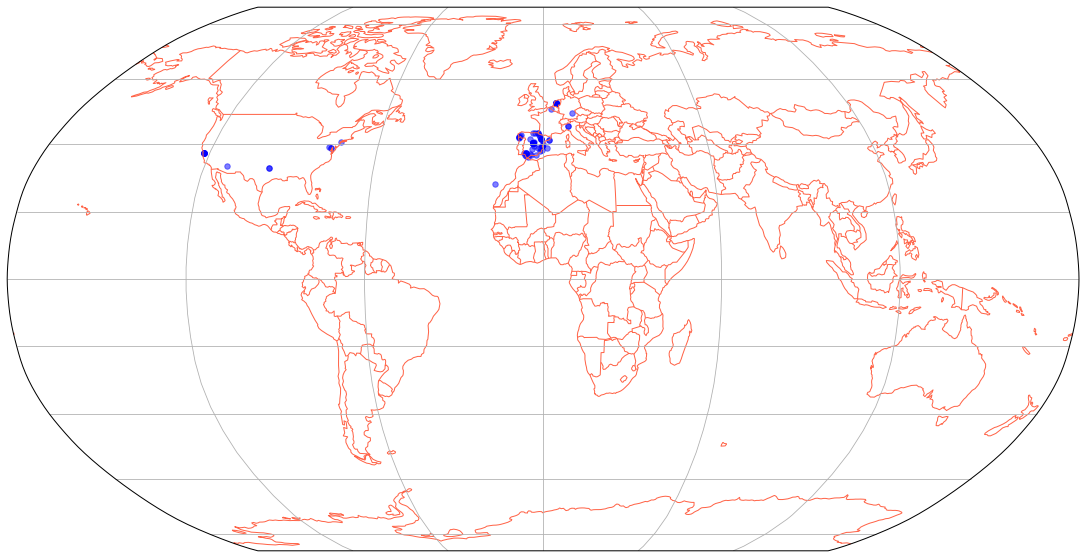

In [70]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1, projection=crs.Robinson())
ax.set_global()
ax.add_feature(cfeature.COASTLINE, edgecolor="tomato")
ax.add_feature(cfeature.BORDERS, edgecolor="tomato")
ax.gridlines()
for keys,values in data.items():   
    plt.scatter(float(values['alt']), float(values['long']),
            color="Blue",
            s=30,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important
plt.show()

In [71]:
values

{'city': 'Madrid', 'long': '40.416500', 'alt': '-3.702560'}

#### Mapa con nombre de ciudades

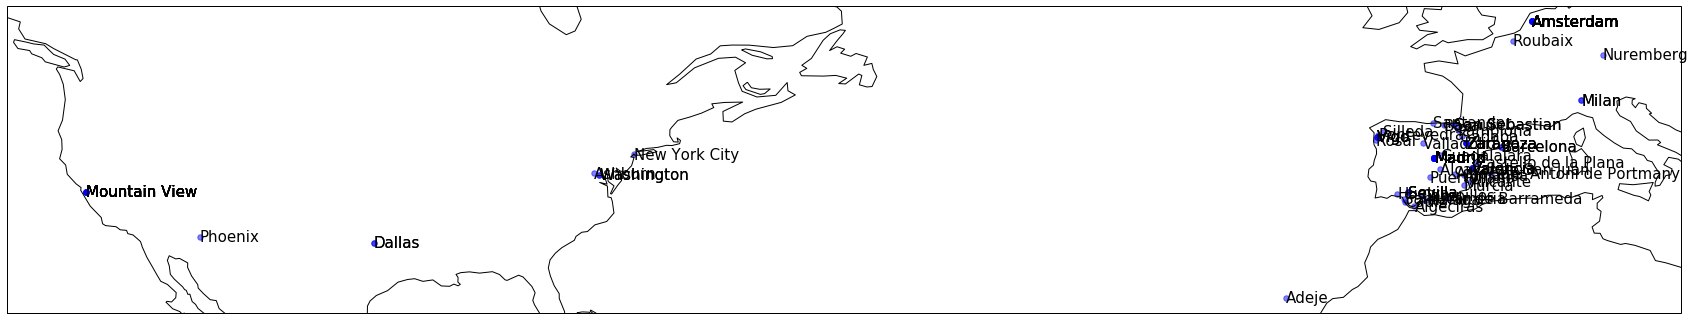

In [72]:
fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)

for keys,values in data.items():    
    plt.scatter(float(values['alt']), float(values['long']),
                color="Blue",
                s=30,
                alpha=0.5,
                transform=crs.PlateCarree()) ## Important
#Añadimos el nombre de la ciudad.
    plt.text(float(values['alt']), float(values['long']),
             values['city'],
             color="black", fontsize=15,
             horizontalalignment="left", verticalalignment="center",
             transform=crs.Geodetic()) ## Important          
plt.show()

Vemos que las conexiones se han realizado desde Europa (principalmente España) y Estados Unidos.

### 2.Evolución logs por días

In [134]:
df_processed.head()

,User,IP_User,Time,Method,Resource,Protocol,Status,Size,Browser
0,localhost,127.0.0.1,23/Feb/2014:03:10:31 +0100,OPTIONS,*,HTTP/1.0,200,-,Apache (internal dummy connection)
1,localhost,127.0.0.1,23/Feb/2014:03:10:31 +0100,OPTIONS,*,HTTP/1.0,200,-,Apache (internal dummy connection)
2,localhost,127.0.0.1,23/Feb/2014:03:10:31 +0100,OPTIONS,*,HTTP/1.0,200,-,Apache (internal dummy connection)
3,localhost,127.0.0.1,23/Feb/2014:03:10:31 +0100,OPTIONS,*,HTTP/1.0,200,-,Apache (internal dummy connection)
4,localhost,127.0.0.1,23/Feb/2014:03:10:31 +0100,OPTIONS,*,HTTP/1.0,200,-,Apache (internal dummy connection)


In [135]:
#Eliminamos localhost IP
df_processed=df_processed[df_processed.User!='localhost']

In [136]:
#Convertimos Time en datetime
df_processed['Time']=(df_processed['Time'].str.split()).str[0]
df_processed['Time']=pd.to_datetime(df_processed['Time'], format='%d/%b/%Y:%H:%M:%S')
df_processed['Time'].head()

22   2014-02-23 03:10:31
23   2014-02-23 03:10:33
24   2014-02-23 03:10:35
25   2014-02-23 03:10:38
26   2014-02-23 03:10:39
Name: Time, dtype: datetime64[ns]

In [137]:
#Hacemos una tabla cruzada y agrupamos por días
df_logs=pd.crosstab(df_processed.Time, df_processed.Status)
df_logs=df_logs.resample('1D').sum()
df_logs

Status,200,301,302,304,401,403,404,500,502
Time,,,,,,,,,
2014-02-23,21466,80,0,233,0,0,6014,0,11
2014-02-24,11168,107,4,270,1,0,2223,0,6
2014-02-25,16679,100,3,183,1,0,183,0,6
2014-02-26,9664,122,2,299,1,0,65,2,5
2014-02-27,5997,111,4,332,1,1,52,0,8
2014-02-28,4369,230,0,305,1,0,21,0,2
2014-03-01,4441,78,2,226,0,0,6,0,4
2014-03-02,300,11,0,20,0,0,0,0,0


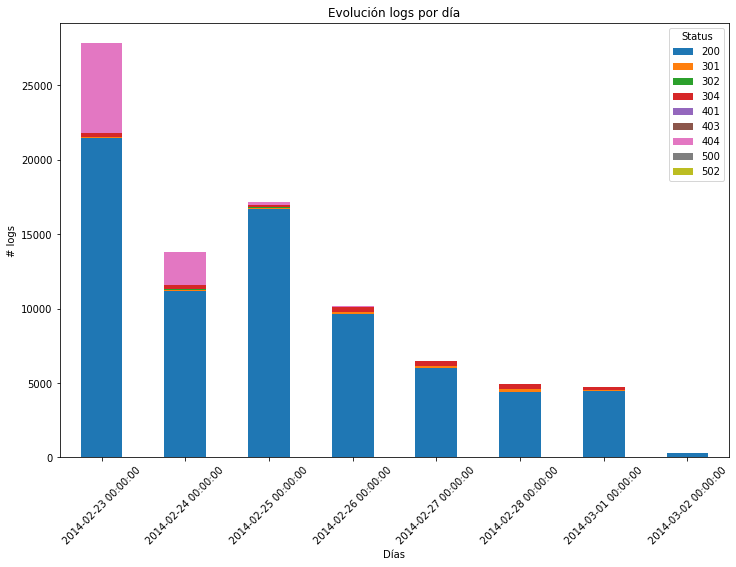

In [139]:
#Mostramos gráfico con la cantidad de logs desglosados por Status
df_logs.plot.bar(stacked=True,figsize=(12,8),title='Evolución logs por día', rot=45)
plt.xlabel('Días')
plt.ylabel('# logs')
plt.show()

El mayor tráfico se produjo el primer día, el 23 de Febrero, y después se fue reduciéndo rápidamente hasta el 3 de Marzo. Casi todos los logs tuvieron un código 200, (OK), por lo que la conexión tuvo éxito. Sólo el primer y segundo día hubieron algunas conexiones con código 404 que nos indica que la página o recurso solicitado no existía.

### 3.Bag of words

In [85]:
import re
from wordcloud import WordCloud, STOPWORDS
df_processed =  df_processed[ df_processed['Resource'].notnull()]
words=pd.Series([y for x in df_processed.Resource.values.flatten() for y in  re.split('[- / % .]', x)]).value_counts()[0:20]
words=words.reset_index()
words.columns=['word','quantity']
words

,word,quantity
0,,93573
1,baratos,81119
2,en,70254
3,hoteles,68848
4,destinos,63505
5,con,48938
6,C3,36771
7,caracteristicas,24018
8,destinosCaracteristicas,17330
9,html,16865


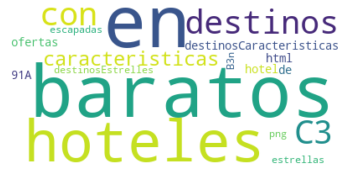

In [86]:
text = " ".join(review for review in prueba['index'])
stopwords = set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Por el gráfico vemos que la mayoría de consultas estaban relacionadas con hoteles, precios baratos, ofertas, etc.